# DBSCAN Clustering

#### 1. Introduction
#### 2. Importing Required Libraries
#### 3. Loading Processed Data
#### 4. Understanding DBSCAN Parameters
#### 5. Applying DBSCAN
#### 6. Cluster Visualization
#### 7. Noise (Outlier) Analysis
#### 8. Cluster Interpretation
#### 9. Summary


## Introduction
DBSCAN is a density-based clustering algorithm that groups together points
that are closely packed while marking points in low-density regions as noise.
Unlike KMeans and Hierarchical clustering, DBSCAN does not require specifying
the number of clusters beforehand.

## Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

## Load Processed Data

In [4]:
with open("../data/processed/mall_customers_scaled.pkl", "rb") as f:
    df_scaled = pickle.load(f)

df_scaled.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Recency,Frequency,Monetary
0,1.128152,-1.424569,-1.738999,-0.434801,0.434801,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704,-1.195704,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913,1.715913,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418,-1.040418,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980,0.395980,-1.662660,-0.395980


## Understanding DBSCAN Parameters
DBSCAN uses two main parameters:

- eps: Maximum distance between two points to be considered neighbors
- min_samples: Minimum number of points required to form a dense region

Points that do not belong to any dense region are labeled as noise (-1).

## Finding Optimal eps using k-distance Graph

The k-distance graph helps estimate a suitable value for eps by identifying
a point where the distance to the k-th nearest neighbor sharply increases.

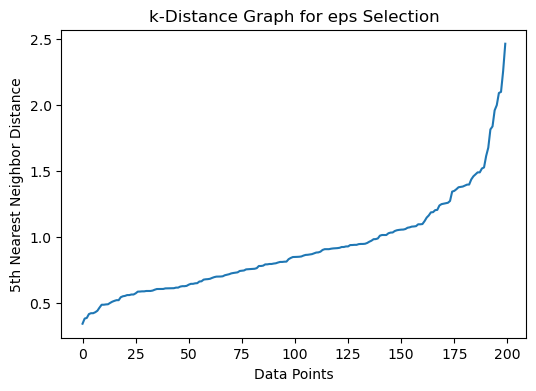

In [5]:
# k-distance Graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

distances = np.sort(distances[:, 4])

plt.figure(figsize=(6,4))
plt.plot(distances)
plt.xlabel("data Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("k-Distance Graph for eps Selection")
plt.show()


The optimal value of eps is approximately 1.0.
+ Below 1.0 → points are well-connected (clusters)
+ Above 1.0 → distances increase rapidly (noise/outliers)

## Initial DBSCAN Model (Exploratory)

In [13]:
dbscan_initial = DBSCAN(eps=0.5, min_samples=5)
labels_initial = dbscan_initial.fit_predict(df_scaled)

np.unique(labels_initial)

array([-1,  0,  1])

The initial DBSCAN result shows either excessive noise or poorly formed clusters.
Therefore, parameter tuning is required.

## Final DBSCAN Model (After Parameter Tuning)

In [19]:
final_dbscan = DBSCAN(eps=1.0, min_samples=5)
final_labels = final_dbscan.fit_predict(df_scaled)

np.unique(final_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

This output tells that there are 8 clusters(0-9) and still some noise is present(-1).

## Attaching Final Cluster Labels

In [20]:
df_final = df_scaled.copy()
df_final['Cluster'] = final_labels

df_final.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Recency,Frequency,Monetary,Cluster
0,1.128152,-1.424569,-1.738999,-0.434801,0.434801,-1.738999,-0.434801,-1
1,1.128152,-1.281035,-1.738999,1.195704,-1.195704,-1.738999,1.195704,1
2,-0.886405,-1.352802,-1.700830,-1.715913,1.715913,-1.700830,-1.715913,-1
3,-0.886405,-1.137502,-1.700830,1.040418,-1.040418,-1.700830,1.040418,0
4,-0.886405,-0.563369,-1.662660,-0.395980,0.395980,-1.662660,-0.395980,-1


## Cluster Distribution and Noise Analysis

In [21]:
df_final['Cluster'].value_counts()

Cluster
 0    61
 3    35
-1    27
 5    19
 7    15
 2    11
 4    11
 1     8
 8     8
 6     5
Name: count, dtype: int64

## Cluster Visualization using PCA

In [22]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
df_pca['Cluster'] = final_labels

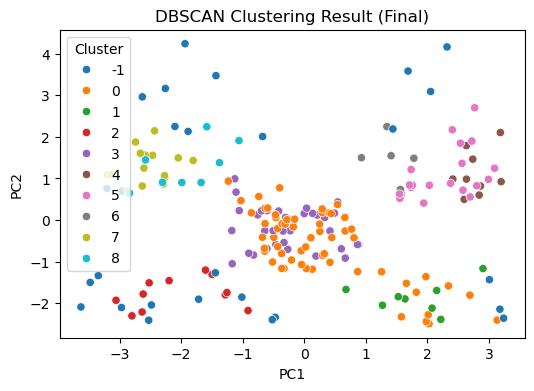

In [23]:
# PCA Scatter Plot

plt.figure(figsize=(6,4))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=df_pca,
    palette='tab10'
)
plt.title("DBSCAN Clustering Result (Final)")
plt.show()

#### Key Observations from the Plot
1. Presence of multiple small clusters

  + DBSCAN has created many small, compact clusters instead of a few large ones

  + This indicates:

    + The data has several local dense regions

    + Customer behavior is not uniformly distributed
   
2. Clear identification of noise (Cluster = -1)

   + Points labeled -1 are scattered and isolated
   + These points do not belong to any dense group
  
3. Central dense region

   + The dense cluster near the center (PC1 ≈ 0, PC2 ≈ 0):

    + Represents typical / average customers

    + Similar income and spending behavior
 
4. Separated dense groups on left and right

  + Groups on the right side (PC1 positive):

   + Likely higher income and/or higher spending customers

  + Groups on the left side (PC1 negative):

   + Likely lower income or lower spending customers

    


## Cluster Profiling (Excluding Noise)

In [24]:
df_final[df_final['Cluster'] != -1].groupby('Cluster').mean()

,Gender,Age,Annual Income (k$),Spending Score (1-100),Recency,Frequency,Monetary
Cluster,,,,,,,
0,-0.886405,-0.078649,-0.373034,0.129702,-0.129702,-0.373034,0.129702
1,1.128152,-0.931173,-1.362076,0.996744,-0.996744,-1.362076,0.996744
2,-0.886405,0.402220,-1.228917,-1.161823,1.161823,-1.228917,-1.161823
3,1.128152,0.478274,-0.198045,-0.028839,0.028839,-0.198045,-0.028839
4,1.128152,-0.243681,0.703844,1.520393,-1.520393,0.703844,1.520393
5,-0.886405,-0.487825,0.870584,1.252915,-1.252915,0.870584,1.252915
6,1.128152,-0.678195,1.016834,0.753138,-0.753138,1.016834,0.753138
7,1.128152,-0.037079,0.828531,-1.501100,1.501100,0.828531,-1.501100
8,-0.886405,0.154298,0.942403,-1.172411,1.172411,0.942403,-1.172411


### Key Interpretation
+ High-value clusters show:

   - High Spending Score, Frequency, and Monetary value

   - Low Recency, indicating recent and frequent purchases

    ➜ Ideal targets for loyalty programs and premium offers

+ Affluent but selective clusters exhibit:

   - High Annual Income but moderate or low Spending

   ➜ Opportunity for upselling and personalized recommendations

+ Low-engagement clusters are characterized by:

    - Low Spending, Frequency, and Monetary value

    ➜ Suitable for discount-based and mass marketing strategies

+ Dormant or at-risk customers display:

   - High Recency with low purchasing activity

   ➜ Require re-engagement and win-back campaigns

+ Average behavior clusters represent:

  - Stable customers with moderate activity across all metrics

  ➜ Can be nurtured to move into higher-value segments

## Summary

After parameter tuning, DBSCAN successfully identified dense customer groups
and labeled sparse points as noise. DBSCAN is particularly useful for detecting
outliers and unusual customer behavior, rather than primary customer segmentation.